In [1]:
# !pip install tensorflow==2.8.0
!pip install efficientnet
!pip install --upgrade wandb
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.9
    Uninstalling wandb-0.15.9:
      Successfully uninstalled wandb-0.15.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 64.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.4 requires botocore<1.31.18,>=1.31.17, but you have botocore 1.29.165 which is incompatible.


In [2]:
import os
import re
import random
import pandas as pd
import numpy as np
import json
import math
import string
import uuid


### Tensorflow Imports
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,confusion_matrix
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Layer, \
                        UpSampling1D, Input, DepthwiseConv2D, Conv2D, \
                        BatchNormalization, ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras.applications import MobileNet


### External models
import efficientnet.tfkeras as efn


### Matplotlib Imports
import matplotlib
import matplotlib.pyplot as plt


### import wandb
import wandb
from wandb.keras import WandbCallback


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config


def download_files(bucket_name, s3_prefix, local_directory):
    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    bucket = s3.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=s3_prefix):
        local_file = os.path.join(local_directory, obj.key)

        if not os.path.exists(os.path.dirname(local_file)):
            os.makedirs(os.path.dirname(local_file))

        bucket.download_file(obj.key, local_file)
        print(f"Downloaded {obj.key} to {local_file}")

download_files('mitdb128x128', 'train', '/content/input')

Downloaded trainfile_class10_fold0_6117.tfrec to /content/input/trainfile_class10_fold0_6117.tfrec
Downloaded trainfile_class10_fold1_6116.tfrec to /content/input/trainfile_class10_fold1_6116.tfrec
Downloaded trainfile_class10_fold2_6116.tfrec to /content/input/trainfile_class10_fold2_6116.tfrec
Downloaded trainfile_class10_fold3_6116.tfrec to /content/input/trainfile_class10_fold3_6116.tfrec
Downloaded trainfile_class10_fold4_6116.tfrec to /content/input/trainfile_class10_fold4_6116.tfrec
Downloaded trainfile_class10_fold5_6116.tfrec to /content/input/trainfile_class10_fold5_6116.tfrec
Downloaded trainfile_class10_fold6_6116.tfrec to /content/input/trainfile_class10_fold6_6116.tfrec
Downloaded trainfile_class10_fold7_6117.tfrec to /content/input/trainfile_class10_fold7_6117.tfrec
Downloaded trainfile_class10_fold8_6116.tfrec to /content/input/trainfile_class10_fold8_6116.tfrec
Downloaded trainfile_class10_fold9_6116.tfrec to /content/input/trainfile_class10_fold9_6116.tfrec


In [4]:
!ls /content/input

trainfile_class10_fold0_6117.tfrec  trainfile_class10_fold5_6116.tfrec
trainfile_class10_fold1_6116.tfrec  trainfile_class10_fold6_6116.tfrec
trainfile_class10_fold2_6116.tfrec  trainfile_class10_fold7_6117.tfrec
trainfile_class10_fold3_6116.tfrec  trainfile_class10_fold8_6116.tfrec
trainfile_class10_fold4_6116.tfrec  trainfile_class10_fold9_6116.tfrec


In [5]:
hparams = {
    "backbone" : "b0",
    "batch_size" : 32,
    "epochs" : 40,
    "img_size" : 128,
    "lr" : 0.01,
    "optimizer" : "adam",
    "seed": 257,
    "notes": "SACC-s-dropout-changes"
}

In [6]:
class WandBConfigurations():
    def __init__(self, exp_name = "ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS"):
        self.EXPERIMENT_NAME = exp_name
        os.environ["WANDB_API_KEY"] = "221507f411c2ddcc0c17238e115a12c528a482f6"
        wandb.login()

WB = WandBConfigurations()

wandb: Currently logged in as: shreya-srivas02. Use `wandb login --relogin` to force relogin


In [7]:
 class Utils():
    def __init__(self):
        self.seed_everything()

    def id_generator(size=6):
        return str(uuid.uuid4())[:size]

    def setupTPU(self):

        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print('Running on TPU ', tpu.cluster_spec().as_dict())
        except ValueError:
            tpu = None

        if tpu:
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            STRATEGY = strategy
            BATCH_SIZE = 8 * strategy.num_replicas_in_sync
            # wandb.config.hardware = 'TPU'
        else:
            strategy = tf.distribute.get_strategy()
            
        return strategy

    def seed_everything(self):
        np.random.seed(hparams['seed'])
        tf.random.set_seed(hparams['seed'])
        random.seed(a=hparams['seed'])
        os.environ['PYTHONHASHSEED'] = str(hparams['seed'])

UTILS = Utils()
STRATEGY = UTILS.setupTPU()

In [8]:
STRATEGY

In [9]:
class Config():
    def __init__(self):
        self.DO_VAL_SPLIT = True
        self.TRAIN_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[:-1]
        self.TOTAL_TRAIN_IMG = 48929
        self.TOTAL_VAL_IMG = 6116
        self.TOTAL_TEST_IMG = 6116
        self.BACKBONE = hparams['backbone']
        self.IMG_TRAIN_SHAPE = [hparams["img_size"],hparams["img_size"]]
        self.DO_FINETUNE = True
        self.BATCH_SIZE = hparams["batch_size"] # 16
        self.EPOCHES = hparams["epochs"]
        self.SEED = hparams["seed"]
        self.LOSS = tf.keras.losses.CategoricalCrossentropy()
        self.OPTIMIZER = self.get_optimizer()
        self.ACCURACY = []
        self.CALLBACKS = []
        self.STRATEGY = STRATEGY
        self.FOLDS = 9
        self.USE_LR_SCHEDULER = True
        self.FOLD_NUMBER = 0
        self.FOLDS_DICT = {}

        if self.USE_LR_SCHEDULER:
            lrfn = self.get_cosine_schedule_with_warmup(lr=hparams['lr'])
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
            self.CALLBACKS.append(lr_schedule)

    def get_optimizer(self):
        if hparams['optimizer'] == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'rmsprop':
            return tf.keras.optimizers.RMSprop(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adagrad':
            return tf.keras.optimizers.Adagrad(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adadelta':
            return tf.keras.optimizers.Adadelta(learning_rate=hparams["lr"])

        return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])

    def get_cosine_schedule_with_warmup(
        self,
        lr = 0.00004,
        num_warmup_steps = 0,
        num_cycles=0.5):
        num_training_steps = self.EPOCHES
        def lrfn(epoch):
            if epoch < num_warmup_steps:
                return (float(epoch) / float(max(5, num_warmup_steps))) * lr
            progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

        return lrfn


CONFIG = Config()

In [10]:
CONFIG.BATCH_SIZE

32

In [11]:
class Data():
    def __init__(self):
        self.LABELED_TFREC_FORMAT = {
            "image_id": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            'target10': tf.io.FixedLenFeature([], tf.int64),
            'gender' : tf.io.FixedLenFeature([], tf.int64),
            'age_interval' : tf.io.FixedLenFeature([], tf.int64),
        }

    def process_training_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10 }

    def process_testing_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)
        image_id = data["image_id"]

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10, "image_id":  data['image_id']}

    def val_dataset(self):
        ignore_order = tf.data.Options()
        val_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(CONFIG.FOLD_NUMBER)]["valfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return val_dataset

    def train_dataset(self):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        train_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(fold_number)]["trainfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).repeat(
            ).shuffle(
                CONFIG.SEED
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return train_dataset

    def test_dataset(self):
        ignore_order = tf.data.Options()
        TEST_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[-1]
        test_dataset = (
            tf.data.TFRecordDataset(
                TEST_FILES,
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_testing_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE *  4
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )
        return test_dataset


In [12]:
class SACCLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(SACCLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='weights_ECG',
                                        shape=(input_shape[0][-1], self.output_dim),
                                        initializer='he_normal',
                                        trainable=True)
        self.kernel_2 = self.add_weight(name='weights_Patient_Metadata',
                                        shape=(input_shape[1][-1], self.output_dim),
                                        initializer='he_normal',
                                        trainable=True)
        self.attention_weights1 = self.add_weight(name='attention_weights_ECG',
                                                 shape=(self.output_dim,),
                                                 initializer='uniform',
                                                 trainable=True)
        self.attention_weights2 = self.add_weight(name='attention_weights_Patient_metadata',
                                                 shape=(self.output_dim,),
                                                 initializer='uniform',
                                                 trainable=True)
        self.dense_layer = tf.keras.layers.Dense(self.output_dim, activation='relu', name='cca_dense')
        super(SACCLayer, self).build(input_shape)

    def call(self, inputs):
        proj_1 = K.dot(inputs[0], self.kernel_1)
        proj_2 = K.dot(inputs[1], self.kernel_2)

        # Apply non-linear transformation
        proj_1 = tf.keras.activations.relu(proj_1)
        proj_2 = tf.keras.activations.relu(proj_2)

        # Attention mechanism
        attention_scores1 = tf.nn.softmax(self.attention_weights1)
        attention_scores2 = tf.nn.softmax(self.attention_weights2)
        proj_1 = attention_scores1 * proj_1
        proj_2 = attention_scores2 * proj_2

        # Non-linear fusion
        fused_representation = tf.keras.layers.concatenate([proj_1, proj_2])
        fused_representation = self.dense_layer(fused_representation)

        return fused_representation

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)


def depthwise_separable_conv_with_residual_block(x, filters, stride):
    # Depthwise Convolution
    depthwise = DepthwiseConv2D((3, 3), strides=stride, padding='same')(x)
    depthwise = BatchNormalization()(depthwise)
    depthwise = ReLU()(depthwise)

    # Pointwise Convolution
    pointwise = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(depthwise)
    pointwise = BatchNormalization()(pointwise)
    pointwise = ReLU()(pointwise)


    return pointwise


def DualPathwayModel(inp1):
    # Initial Convolution Layers
    conv1 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inp1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

#     conv2 = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(inp1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = ReLU()(conv2)
    

#     concatenated = tf.keras.layers.concatenate([conv1, conv2])

    x = depthwise_separable_conv_with_residual_block(conv1, 64, (1, 1))
    x = depthwise_separable_conv_with_residual_block(x, 128, (2, 2))
    x = tf.keras.layers.Dropout(0.25)(x)
    x = depthwise_separable_conv_with_residual_block(x, 128, (2, 2))
    x = depthwise_separable_conv_with_residual_block(x, 256, (2, 2))
    x = tf.keras.layers.Dropout(0.25)(x)
    x = depthwise_separable_conv_with_residual_block(x, 256, (2, 2))
    x = depthwise_separable_conv_with_residual_block(x, 256, (2, 2)) #<--- Can be removed

    return x

    
def dpm_sacc():
    inp1  = tf.keras.layers.Input(shape = (*CONFIG.IMG_TRAIN_SHAPE, 1), name='inp1')
    inp2  = tf.keras.layers.Input(shape = (2,), name='inp2')
    x1 = DualPathwayModel(inp1)

    x1 = tf.keras.layers.GlobalMaxPooling2D()(x1) # AVG is not good
    x1 = tf.keras.layers.Dropout(0.2)(x1)

    x2 = tf.keras.layers.Dense(8, name='metadata_feature_dense_1', activation='relu')(inp2)
    x2 = tf.keras.layers.concatenate([x2, inp2])

    x = SACCLayer(output_dim=256)([x1, x2])
    
    
    x = tf.keras.layers.Dense(128, name='combine_feature_dense_1', activation='relu')(x)
    x = tf.keras.layers.Dense(64, name='combine_feature_dense_2', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    output10 = tf.keras.layers.Dense(10, activation='softmax', name='target10')(x)

    model = tf.keras.models.Model(inputs = [inp1, inp2], outputs = [output10])

    return model

In [13]:
dpm_sacc().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['inp1[0][0]']                   
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [14]:
def fitengine(model, traindataset, valdataset = None, istraining = True):
    model.compile(
        optimizer   =  CONFIG.OPTIMIZER,
        loss        =  CONFIG.LOSS,
        metrics     =  CONFIG.ACCURACY
    )

    history = model.fit(
                traindataset,
                epochs            =   CONFIG.EPOCHES,
                steps_per_epoch   =   CONFIG.TOTAL_TRAIN_IMG//CONFIG.BATCH_SIZE,
                callbacks         =   CONFIG.CALLBACKS,
                validation_data   =   valdataset,
                validation_steps = (CONFIG.TOTAL_VAL_IMG)//(CONFIG.BATCH_SIZE) + 1,
                verbose           =   1
            )

    return history

skf = KFold(n_splits=CONFIG.FOLDS,shuffle=True,random_state=CONFIG.SEED)
for fold_number,(idxT,idxV) in enumerate(skf.split(np.arange(len(CONFIG.TRAIN_FILES)))):
    CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)] = {
                                            "trainfiles" : [CONFIG.TRAIN_FILES[x] for x in idxT],
                                            "valfiles"   : [CONFIG.TRAIN_FILES[x] for x in idxV]
                                            }

fold_number = CONFIG.FOLD_NUMBER
print(CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)]['trainfiles'])
print(CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)]['valfiles'])

run_ = wandb.init(
    project= WB.EXPERIMENT_NAME,
    reinit=True,
    dir = "/root",
    allow_val_change = True,
    config = hparams
)

if CONFIG.STRATEGY is not None:
    with CONFIG.STRATEGY.scope():
        x2 = tf.keras.metrics.Precision(name='precision')
        x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
        x4 = tf.keras.metrics.Recall(name='sensitivity')

        CONFIG.ACCURACY.append(x2)
        CONFIG.ACCURACY.append(x3)
        CONFIG.ACCURACY.append(x4)

        model = dpm_sacc()
#         CONFIG.CALLBACKS.append(InLayerLossCallback())
else:
    x2 = tf.keras.metrics.Precision(name='precision')
    x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
    x4 = tf.keras.metrics.Recall(name='sensitivity')
    x4 = tf.keras.metrics.Recall(name='sensitivity')

    CONFIG.ACCURACY.append(x2)
    CONFIG.ACCURACY.append(x3)
    CONFIG.ACCURACY.append(x4)

    model = dpm_sacc()

CONFIG.CALLBACKS.append(tf.keras.callbacks.ModelCheckpoint(
                                'model-%s.h5'%(fold_number), monitor='val_loss', verbose=1, save_best_only=True,
                                save_weights_only=True, mode='min', save_freq='epoch'))

CONFIG.CALLBACKS.append(WandbCallback(save_weights_only=True,
                                            log_weights=True,
                                            log_evaluation=True))




DATA = Data()

print("##"*30)

history = fitengine(model, DATA.train_dataset(), valdataset=DATA.val_dataset()) #training model

print('##'*30)

['/content/input/trainfile_class10_fold0_6117.tfrec', '/content/input/trainfile_class10_fold1_6116.tfrec', '/content/input/trainfile_class10_fold2_6116.tfrec', '/content/input/trainfile_class10_fold4_6116.tfrec', '/content/input/trainfile_class10_fold5_6116.tfrec', '/content/input/trainfile_class10_fold6_6116.tfrec', '/content/input/trainfile_class10_fold7_6117.tfrec', '/content/input/trainfile_class10_fold8_6116.tfrec']
['/content/input/trainfile_class10_fold3_6116.tfrec']


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


############################################################


wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


Epoch 1/40


2023-11-03 18:12:21.985603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1529/1529 [==============================] - ETA: 0s - loss: 0.5118 - precision: 0.9091 - accuracy: 0.9730 - sensitivity: 0.8114
Epoch 1: val_loss improved from inf to 3.65455, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 89s 44ms/step - loss: 0.5118 - precision: 0.9091 - accuracy: 0.9730 - sensitivity: 0.8114 - val_loss: 3.6545 - val_precision: 0.1015 - val_accuracy: 0.8764 - val_sensitivity: 0.0301 - lr: 0.0100
Epoch 2/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.2570 - precision: 0.9400 - accuracy: 0.9865 - sensitivity: 0.9238
Epoch 2: val_loss did not improve from 3.65455
1529/1529 [==============================] - 59s 38ms/step - loss: 0.2570 - precision: 0.9400 - accuracy: 0.9865 - sensitivity: 0.9238 - val_loss: 5.1361 - val_precision: 0.0630 - val_accuracy: 0.8157 - val_sensitivity: 0.0608 - lr: 0.0100
Epoch 3/40
1529/1529 [==============================] - ETA: 0s - loss: 0.2122 - precision: 0.9494 - accuracy: 0.9887 - sensitivity: 0.9374
Epoch 3: val_loss improved from 3.65455 to 0.34772, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 67s 44ms/step - loss: 0.2122 - precision: 0.9494 - accuracy: 0.9887 - sensitivity: 0.9374 - val_loss: 0.3477 - val_precision: 0.9238 - val_accuracy: 0.9799 - val_sensitivity: 0.8705 - lr: 0.0099
Epoch 4/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1883 - precision: 0.9554 - accuracy: 0.9899 - sensitivity: 0.9435
Epoch 4: val_loss did not improve from 0.34772
1529/1529 [==============================] - 58s 38ms/step - loss: 0.1883 - precision: 0.9554 - accuracy: 0.9899 - sensitivity: 0.9435 - val_loss: 2.7038 - val_precision: 0.2815 - val_accuracy: 0.8627 - val_sensitivity: 0.2400 - lr: 0.0099
Epoch 5/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.1719 - precision: 0.9587 - accuracy: 0.9906 - sensitivity: 0.9472
Epoch 5: val_loss did not improve from 0.34772
1529/1529 [==============================] - 58s 38ms/step - loss: 0.1719 - precision: 0.9587 - accuracy: 0.9906 - sensitivity: 0.9472 - val_loss:

wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 67s 44ms/step - loss: 0.1421 - precision: 0.9653 - accuracy: 0.9919 - sensitivity: 0.9533 - val_loss: 0.2526 - val_precision: 0.9434 - val_accuracy: 0.9863 - val_sensitivity: 0.9184 - lr: 0.0095
Epoch 8/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1369 - precision: 0.9658 - accuracy: 0.9922 - sensitivity: 0.9564
Epoch 8: val_loss improved from 0.25260 to 0.11491, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 68s 44ms/step - loss: 0.1369 - precision: 0.9658 - accuracy: 0.9922 - sensitivity: 0.9564 - val_loss: 0.1149 - val_precision: 0.9708 - val_accuracy: 0.9937 - val_sensitivity: 0.9660 - lr: 0.0093
Epoch 9/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.1292 - precision: 0.9675 - accuracy: 0.9926 - sensitivity: 0.9584
Epoch 9: val_loss did not improve from 0.11491
1529/1529 [==============================] - 59s 38ms/step - loss: 0.1291 - precision: 0.9675 - accuracy: 0.9926 - sensitivity: 0.9584 - val_loss: 1.4481 - val_precision: 0.7127 - val_accuracy: 0.9355 - val_sensitivity: 0.5952 - lr: 0.0090
Epoch 10/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1220 - precision: 0.9690 - accuracy: 0.9931 - sensitivity: 0.9619
Epoch 10: val_loss did not improve from 0.11491
1529/1529 [==============================] - 59s 38ms/step - loss: 0.1220 - precision: 0.9690 - accuracy: 0.9931 - sensitivity: 0.9619 - val_los

wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 70s 46ms/step - loss: 0.1148 - precision: 0.9704 - accuracy: 0.9934 - sensitivity: 0.9631 - val_loss: 0.1082 - val_precision: 0.9726 - val_accuracy: 0.9940 - val_sensitivity: 0.9675 - lr: 0.0082
Epoch 13/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.1044 - precision: 0.9733 - accuracy: 0.9941 - sensitivity: 0.9673
Epoch 13: val_loss did not improve from 0.10816
1529/1529 [==============================] - 58s 38ms/step - loss: 0.1045 - precision: 0.9732 - accuracy: 0.9941 - sensitivity: 0.9672 - val_loss: 0.6240 - val_precision: 0.8578 - val_accuracy: 0.9620 - val_sensitivity: 0.7436 - lr: 0.0079
Epoch 14/40
1529/1529 [==============================] - ETA: 0s - loss: 0.1014 - precision: 0.9735 - accuracy: 0.9942 - sensitivity: 0.9679
Epoch 14: val_loss did not improve from 0.10816
1529/1529 [==============================] - 62s 40ms/step - loss: 0.1014 - precision: 0.9735 - accuracy: 0.9942 - sensitivity: 0.9679 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 66s 43ms/step - loss: 0.0869 - precision: 0.9772 - accuracy: 0.9950 - sensitivity: 0.9723 - val_loss: 0.1078 - val_precision: 0.9718 - val_accuracy: 0.9937 - val_sensitivity: 0.9652 - lr: 0.0065
Epoch 18/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.0799 - precision: 0.9791 - accuracy: 0.9955 - sensitivity: 0.9753
Epoch 18: val_loss did not improve from 0.10780
1529/1529 [==============================] - 60s 39ms/step - loss: 0.0799 - precision: 0.9791 - accuracy: 0.9955 - sensitivity: 0.9753 - val_loss: 1.2214 - val_precision: 0.7085 - val_accuracy: 0.9362 - val_sensitivity: 0.6143 - lr: 0.0062
Epoch 19/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.0752 - precision: 0.9802 - accuracy: 0.9957 - sensitivity: 0.9766
Epoch 19: val_loss did not improve from 0.10780
1529/1529 [==============================] - 59s 39ms/step - loss: 0.0752 - precision: 0.9802 - accuracy: 0.9957 - sensitivity: 0.9766 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 67s 44ms/step - loss: 0.0623 - precision: 0.9835 - accuracy: 0.9964 - sensitivity: 0.9809 - val_loss: 0.1049 - val_precision: 0.9720 - val_accuracy: 0.9939 - val_sensitivity: 0.9663 - lr: 0.0046
Epoch 23/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.0603 - precision: 0.9837 - accuracy: 0.9965 - sensitivity: 0.9811
Epoch 23: val_loss improved from 0.10488 to 0.08754, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 68s 44ms/step - loss: 0.0603 - precision: 0.9837 - accuracy: 0.9965 - sensitivity: 0.9811 - val_loss: 0.0875 - val_precision: 0.9800 - val_accuracy: 0.9958 - val_sensitivity: 0.9784 - lr: 0.0042
Epoch 24/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0556 - precision: 0.9847 - accuracy: 0.9967 - sensitivity: 0.9823
Epoch 24: val_loss did not improve from 0.08754
1529/1529 [==============================] - 58s 38ms/step - loss: 0.0556 - precision: 0.9847 - accuracy: 0.9967 - sensitivity: 0.9823 - val_loss: 0.6523 - val_precision: 0.8342 - val_accuracy: 0.9609 - val_sensitivity: 0.7601 - lr: 0.0038
Epoch 25/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0525 - precision: 0.9856 - accuracy: 0.9970 - sensitivity: 0.9840
Epoch 25: val_loss did not improve from 0.08754
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0525 - precision: 0.9856 - accuracy: 0.9970 - sensitivity: 0.9840 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 69s 45ms/step - loss: 0.0487 - precision: 0.9870 - accuracy: 0.9972 - sensitivity: 0.9847 - val_loss: 0.0848 - val_precision: 0.9807 - val_accuracy: 0.9961 - val_sensitivity: 0.9799 - lr: 0.0031
Epoch 27/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.0445 - precision: 0.9870 - accuracy: 0.9972 - sensitivity: 0.9847
Epoch 27: val_loss did not improve from 0.08480
1529/1529 [==============================] - 62s 40ms/step - loss: 0.0445 - precision: 0.9870 - accuracy: 0.9972 - sensitivity: 0.9848 - val_loss: 0.0901 - val_precision: 0.9817 - val_accuracy: 0.9963 - val_sensitivity: 0.9810 - lr: 0.0027
Epoch 28/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.0449 - precision: 0.9872 - accuracy: 0.9973 - sensitivity: 0.9856
Epoch 28: val_loss improved from 0.08480 to 0.08242, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 67s 44ms/step - loss: 0.0449 - precision: 0.9872 - accuracy: 0.9973 - sensitivity: 0.9856 - val_loss: 0.0824 - val_precision: 0.9825 - val_accuracy: 0.9963 - val_sensitivity: 0.9801 - lr: 0.0024
Epoch 29/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0427 - precision: 0.9886 - accuracy: 0.9975 - sensitivity: 0.9864
Epoch 29: val_loss did not improve from 0.08242
1529/1529 [==============================] - 59s 39ms/step - loss: 0.0427 - precision: 0.9886 - accuracy: 0.9975 - sensitivity: 0.9864 - val_loss: 0.0948 - val_precision: 0.9792 - val_accuracy: 0.9956 - val_sensitivity: 0.9763 - lr: 0.0021
Epoch 30/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0399 - precision: 0.9889 - accuracy: 0.9976 - sensitivity: 0.9870
Epoch 30: val_loss did not improve from 0.08242
1529/1529 [==============================] - 59s 39ms/step - loss: 0.0399 - precision: 0.9889 - accuracy: 0.9976 - sensitivity: 0.9870 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 70s 46ms/step - loss: 0.0369 - precision: 0.9897 - accuracy: 0.9978 - sensitivity: 0.9882 - val_loss: 0.0810 - val_precision: 0.9838 - val_accuracy: 0.9966 - val_sensitivity: 0.9822 - lr: 0.0015
Epoch 32/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0332 - precision: 0.9905 - accuracy: 0.9979 - sensitivity: 0.9889
Epoch 32: val_loss did not improve from 0.08097
1529/1529 [==============================] - 59s 38ms/step - loss: 0.0332 - precision: 0.9905 - accuracy: 0.9979 - sensitivity: 0.9889 - val_loss: 0.0828 - val_precision: 0.9831 - val_accuracy: 0.9965 - val_sensitivity: 0.9819 - lr: 0.0012
Epoch 33/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0340 - precision: 0.9903 - accuracy: 0.9979 - sensitivity: 0.9888
Epoch 33: val_loss did not improve from 0.08097
1529/1529 [==============================] - 61s 40ms/step - loss: 0.0340 - precision: 0.9903 - accuracy: 0.9979 - sensitivity: 0.9888 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 71s 46ms/step - loss: 0.0307 - precision: 0.9907 - accuracy: 0.9980 - sensitivity: 0.9892 - val_loss: 0.0802 - val_precision: 0.9823 - val_accuracy: 0.9963 - val_sensitivity: 0.9810 - lr: 3.8060e-04
Epoch 37/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0300 - precision: 0.9913 - accuracy: 0.9981 - sensitivity: 0.9899
Epoch 37: val_loss improved from 0.08022 to 0.07895, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 71s 46ms/step - loss: 0.0300 - precision: 0.9913 - accuracy: 0.9981 - sensitivity: 0.9899 - val_loss: 0.0789 - val_precision: 0.9831 - val_accuracy: 0.9965 - val_sensitivity: 0.9817 - lr: 2.4472e-04
Epoch 38/40
1529/1529 [==============================] - ETA: 0s - loss: 0.0287 - precision: 0.9915 - accuracy: 0.9982 - sensitivity: 0.9904
Epoch 38: val_loss improved from 0.07895 to 0.07874, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 69s 45ms/step - loss: 0.0287 - precision: 0.9915 - accuracy: 0.9982 - sensitivity: 0.9904 - val_loss: 0.0787 - val_precision: 0.9836 - val_accuracy: 0.9966 - val_sensitivity: 0.9823 - lr: 1.3815e-04
Epoch 39/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.0266 - precision: 0.9921 - accuracy: 0.9983 - sensitivity: 0.9909
Epoch 39: val_loss did not improve from 0.07874
1529/1529 [==============================] - 59s 38ms/step - loss: 0.0266 - precision: 0.9921 - accuracy: 0.9983 - sensitivity: 0.9909 - val_loss: 0.0789 - val_precision: 0.9831 - val_accuracy: 0.9965 - val_sensitivity: 0.9819 - lr: 6.1558e-05
Epoch 40/40
1528/1529 [============================>.] - ETA: 0s - loss: 0.0288 - precision: 0.9913 - accuracy: 0.9981 - sensitivity: 0.9901
Epoch 40: val_loss improved from 0.07874 to 0.07869, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231103_181115-j38ogcs7/files/model-best)... Done. 0.0s


1529/1529 [==============================] - 68s 45ms/step - loss: 0.0288 - precision: 0.9913 - accuracy: 0.9981 - sensitivity: 0.9901 - val_loss: 0.0787 - val_precision: 0.9831 - val_accuracy: 0.9965 - val_sensitivity: 0.9822 - lr: 1.5413e-05
############################################################


In [15]:
model.save('model_last_epoch.h5')
model_till_last_epoch = model
SAVED_MODEL_LOC = "model-0.h5"
model = dpm_sacc()
model.load_weights(SAVED_MODEL_LOC)

48/48 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           /     0.9974    0.9974    0.9974       382
           A     0.9258    0.8653    0.8945       245
           F     0.8904    0.8553    0.8725        76
           L     0.9988    0.9988    0.9988       801
           N     0.9826    0.9911    0.9868      3252
           R     0.9932    0.9915    0.9923       586
           V     0.9663    0.9649    0.9656       713
           a     0.7500    0.5455    0.6316        11
           f     1.0000    0.9524    0.9756        21
           j     0.7692    0.6897    0.7273        29

    accuracy                         0.9804      6116
   macro avg     0.9274    0.8852    0.9042      6116
weighted avg     0.9800    0.9804    0.9801      6116

48/48 [==============================] - 1s 13ms/step


wandb: Adding directory to artifact (/kaggle/working)... Done. 0.0s


              precision    recall  f1-score   support

           /     0.9974    0.9974    0.9974       382
           A     0.9258    0.8653    0.8945       245
           F     0.8904    0.8553    0.8725        76
           L     0.9988    0.9988    0.9988       801
           N     0.9826    0.9911    0.9868      3252
           R     0.9932    0.9915    0.9923       586
           V     0.9663    0.9649    0.9656       713
           a     0.7500    0.5455    0.6316        11
           f     1.0000    0.9524    0.9756        21
           j     0.7692    0.6897    0.7273        29

    accuracy                         0.9804      6116
   macro avg     0.9274    0.8852    0.9042      6116
weighted avg     0.9800    0.9804    0.9801      6116



<Artifact Full_Logs>

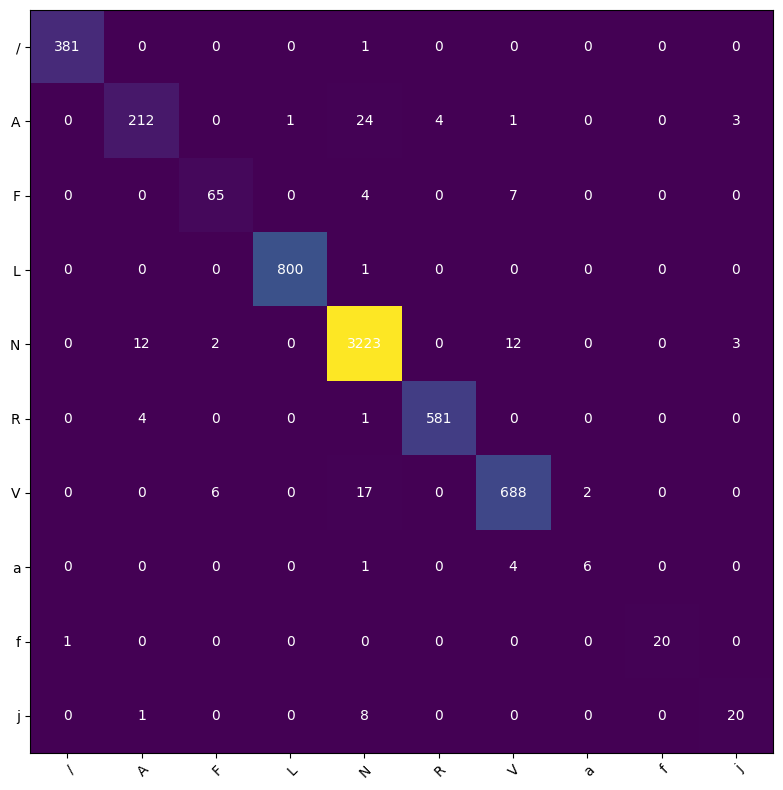

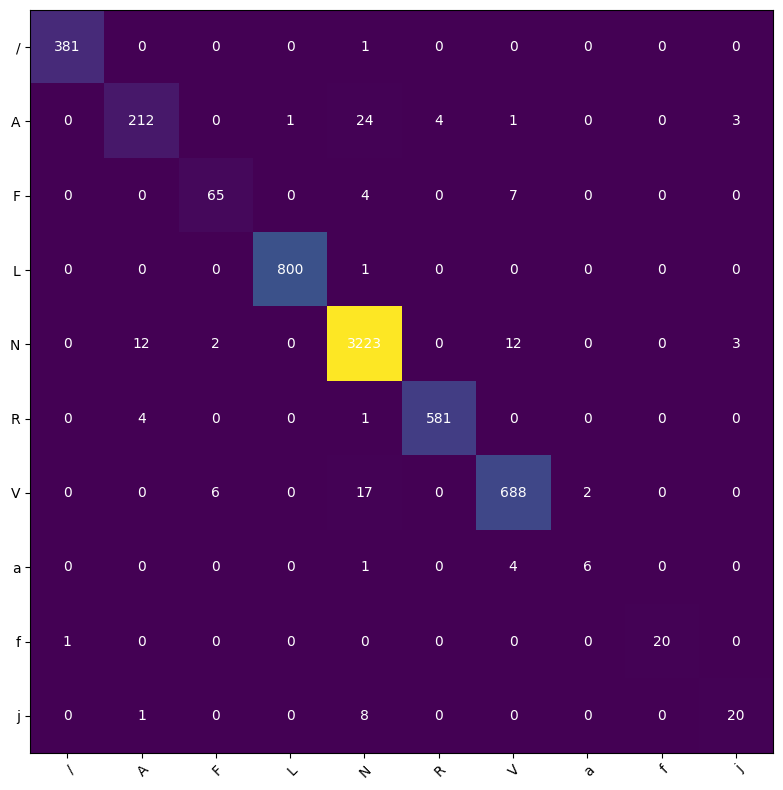

In [16]:
NAME = ['/', "A",  'F', 'L', 'N', 'R', 'V', 'a', 'f', 'j']
for model_type, trained_model in zip(['best_epoch', 'last_epoch'], [model, model_till_last_epoch]):
    test_imgs = DATA.test_dataset().map(lambda data, ids: data)
    img_labels_ds = DATA.test_dataset().map(lambda data, ids: ids).unbatch()

    STEPS = (CONFIG.TOTAL_TEST_IMG)//(CONFIG.BATCH_SIZE*4) + 1

    y_pred = trained_model.predict(test_imgs,steps = int(STEPS), verbose=1)
    test_labels = next(iter(img_labels_ds.batch(int(CONFIG.TOTAL_TEST_IMG) + 1)))
    y_true = test_labels["target10"].numpy()
    pd.DataFrame({
            'image_id'  : test_labels["image_id"].numpy(),
            'actual'  : np.argmax(y_true, axis=1),
            'predicted'      : np.argmax(y_pred, axis=1)
            }).to_csv('prediction_{}.csv'.format(model_type), index=False)

    df = pd.read_csv("prediction_{}.csv".format(model_type))

    run_.log({f"{model_type}_pr": wandb.plot.pr_curve(np.argmax(y_true, axis=1), y_pred, labels=NAME)})
    run_.log({f"{model_type}_roc": wandb.plot.roc_curve(np.argmax(y_true, axis=1), y_pred, labels=NAME)})

    cm = wandb.plot.confusion_matrix(
                    y_true=np.argmax(y_true, axis=1),
                    preds=np.argmax(y_pred, axis=1),
                    class_names=NAME)

    run_.log({f"{model_type}_conf_mat": cm})

    harvest = confusion_matrix(df['actual'], df['predicted'])
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(harvest)
    ax.set_xticks(np.arange(len(NAME)))
    ax.set_yticks(np.arange(len(NAME)))
    ax.set_xticklabels(NAME)
    ax.set_yticklabels(NAME)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    for i in range(len(NAME)):
        for j in range(len(NAME)):
            text = ax.text(j, i, harvest[i, j],
                        ha="center", va="center", color="w")

    fig.tight_layout()
    run_.log({f"{model_type}_cm": plt})

    from sklearn.metrics import classification_report
    target_names = NAME
    x_ = classification_report(df['actual'], df['predicted'], target_names=target_names, digits=4)
    x2 = classification_report(df['actual'], df['predicted'], target_names=target_names, digits=4, output_dict=True)
    print(x_)
    run_.log({f"{model_type}_CR": x2})


## log more
artifact = wandb.Artifact("Full_Logs", type="logs")
artifact.add_dir("/kaggle/working/")
wandb.log_artifact(artifact)

In [17]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph


def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

model = dpm_sacc()

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )




=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [18]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 64, 64, 32)   320         ['inp1[0][0]']                   
                                                                                                  
 batch_normalization_39 (BatchN  (None, 64, 64, 32)  128         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [19]:
tf.keras.utils.plot_model(
    dpm_sacc(),
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

run_.finish()

accuracy,▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
precision,▁▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
sensitivity,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_accuracy,▃▁▇▃▇▇██▆▄▃█▇▇███▆█▇███▇▇███████████████
val_loss,▆█▁▅▂▂▁▁▃▄▅▁▂▂▁▁▁▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▁█▃▇▇██▆▄▃█▇▇███▆█████▇▇███████████████
val_sensitivity,▁▁▇▃▆▇██▅▃▃█▆▆███▅█▇███▆▇███████████████
accuracy,0.99814
